In [7]:
import sys, os, time, datetime, h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import norm, expon, chi2, uniform, chisquare

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import metrics, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow import Variable
from tensorflow import linalg as la

In [2]:
from NN_v2 import *
from PLOTutils import *

# Parameters

In [3]:
seed = 5839
np.random.seed(seed)
print('Random seed: '+str(seed))

# statistics                                                                                                                                                     
N_ref      = 200000
N_Bkg      = 2000
N_Sig      = 10
N_R        = N_ref
N_D        = N_Bkg

# nuisance                                                                                                                                                       
scale   = 0
norm    = 0
sigma_s = 0.15
sigma_n = 0.15

# training time                                                                                                                                                  
total_epochs_tau   = 20000
patience_tau       = 1000
total_epochs_delta = 20000
patience_delta     = 1000

# architecture                                                                                                                                                   
inputsize       = 1
latentsize      = 4
n_layers        = 1
weight_clipping = 9
layers          = [inputsize]

for _ in range(n_layers):
    layers.append(latentsize)
layers.append(1)
print(layers)
hidden_layers = layers[1:-1]

Random seed: 5839
[1, 4, 1]


In [4]:
bins_code = {                                                                                                                                                                                                                                                                         
    'mass': np.arange(0, 10, 0.1)                                                                                                                             
}  
ymax_code = {                                                                                                                                                                                                                                                                       
    'mass': 15                                                                                                                             
}  
xlabel_code = {                                                                                                                                                                                                                                                                        
    'mass': r'$m_{ll}$',                                                                                                                            
}  
feature_labels = list(bins_code.keys())

# DATA

In [5]:
N_Bkg_Pois  = np.random.poisson(lam=N_Bkg*np.exp(norm), size=1)[0]
if N_Sig:
    N_Sig_Pois = np.random.poisson(lam=N_Sig*np.exp(norm), size=1)[0]

featureData = np.random.exponential(scale=np.exp(1*scale), size=(N_Bkg_Pois, 1))
if N_Sig:
    featureSig  = np.random.normal(loc=6.4, scale=0.16, size=(N_Sig_Pois,1))*np.exp(scale)
    featureData = np.concatenate((featureData, featureSig), axis=0)
featureRef  = np.random.exponential(scale=1., size=(N_ref, 1))
feature     = np.concatenate((featureData, featureRef), axis=0)

# target                                                                                                                                                         
targetData  = np.ones_like(featureData)
targetRef   = np.zeros_like(featureRef)
weightsData = np.ones_like(featureData)
weightsRef  = np.ones_like(featureRef)*N_D*1./N_R
target      = np.concatenate((targetData, targetRef), axis=0)
weights     = np.concatenate((weightsData, weightsRef), axis=0)
target      = np.concatenate((target, weights), axis=1)

batch_size  = feature.shape[0]
inputsize   = feature.shape[1]

### plot input samples

<ipython-input-75-8f341141dd6f>:31: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')


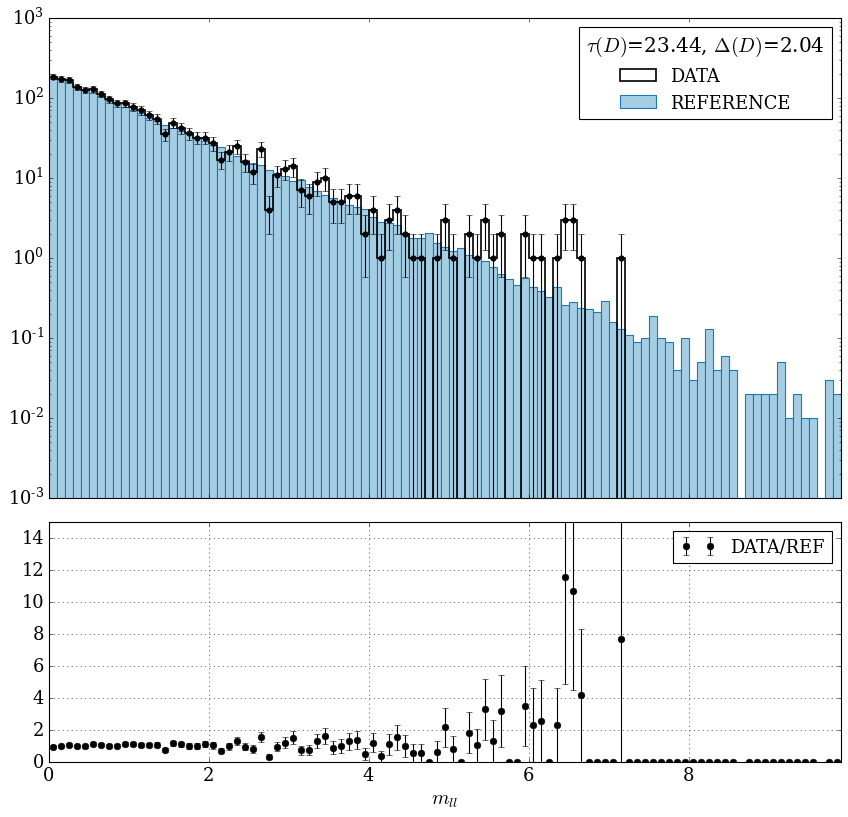

In [75]:
REF    = feature[target[:, 0]==0]
DATA   = feature[target[:, 0]==1]
weight = target[:, 1]

weight_REF       = weight[target[:, 0]==0]
weight_DATA      = weight[target[:, 0]==1]

plt_i = 0
for key in feature_labels:
    bins = bins_code[key]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(10, 10))                                                                                                                                            
    fig.patch.set_facecolor('white')                                                                                                                                              
    ax1 = fig.add_axes([0., 0.33, 0.99, 0.6])        
    hD = plt.hist(DATA[:, plt_i],weights=weight_DATA, 
                  bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=4)
    hR = plt.hist(REF[:, plt_i], weights=weight_REF, color='#a6cee3',     
                  ec='#1f78b4', bins=bins, lw=1, label='REFERENCE')
    plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
    font = font_manager.FontProperties(family='serif', size=16)
    l    = plt.legend(fontsize=18, prop=font)
    font = font_manager.FontProperties(family='serif', size=18) 
    l.set_title(title=r'$\tau(D)$='+str(np.around(tau_OBS, 2))+r', $\Delta(D)$='+str(np.around(delta_OBS, 2)), prop=font)
    plt.tick_params(axis='x', which='both',    labelbottom=False)
    plt.yticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    plt.yscale('log')
    ax2 = fig.add_axes([0., 0., 0.99, 0.3]) 
    x = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
    font = font_manager.FontProperties(family='serif', size=16)
    plt.legend(fontsize=18, prop=font)
    plt.xlabel(xlabel_code[key], fontsize=18, fontname='serif')
    plt.ylim(0., ymax_code[key])
    plt.yticks(fontsize=16, fontname='serif')
    plt.xticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    
    plt.grid() 
    plt.show()
    plt_i+=1

# NN model arguments 

In [76]:
sb0             = np.random.normal(loc=scale, scale=sigma_s, size=1)[0]
eb0             = np.random.normal(loc=norm, scale=sigma_n, size=1)[0]
NUmatrix        = np.array([[0.,            0.            ]])
NURmatrix       = np.array([[0.,            0.            ]])
NU0matrix       = np.array([[sb0,           eb0           ]])
SIGMAmatrix     = np.array([[sigma_s,       sigma_n       ]])
                                                                                                                                                     
input_shape     = (None, inputsize)
points          = []
A0matrix        = []
A1matrix        = []
A2matrix        = []
edgebinlist     = []
means           = []
binned_features = []
                                                                                                            
ParNet_weights  = '/eos/user/g/ggrosso/PhD/BSM/C_PARAMETRIC/LINEAR/Parametric_EXPO1D_batches_ref40000_bkg40000_sigmaS0.1_-1.0_-0.5_0.5_1.0_patience300_epochs30000_layers1_4_1_actrelu/model_weights9300.h5'

# Tau term

In [77]:
tau = NPLMupgrade(input_shape=input_shape, N_Bkg=N_Bkg,
                   NUmatrix=NUmatrix, NURmatrix=NURmatrix, NU0matrix=NU0matrix, SIGMAmatrix=SIGMAmatrix,
                   #A0matrix=A0matrix, A1matrix=A1matrix, A2matrix=A2matrix,
                   #edgebinlist=edgebinlist,  means=means,
                   #points=points, binned_features=binned_features,
                   ParNet_weights=ParNet_weights, correction='PAR',
                   architecture=layers, weight_clipping=weight_clipping, train_f=True, newpar=True)
print(tau.summary())

Model: "npl_mupgrade_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
parametric_net_5 (Parametric multiple                  13        
_________________________________________________________________
bs_mfinder_9 (BSMfinder)     multiple                  13        
Total params: 34
Trainable params: 15
Non-trainable params: 19
_________________________________________________________________
None


In [78]:
tau.compile(loss=NPLLoss_New,  optimizer='adam')

In [79]:
t0=time.time()
hist_tau = tau.fit(feature, target, batch_size=batch_size, epochs=total_epochs_tau, verbose=False)
t1=time.time()
print('Training time (seconds):')
print(t1-t0)

Training time (seconds):
894.3383655548096


In [80]:
# metrics                                                                                                                                                        
loss_tau  = np.array(hist_tau.history['loss'])
scale_tau = np.array(hist_tau.history['scale'])
norm_tau  = np.array(hist_tau.history['norm'])
print('sb_opt: %f, eb_opt: %f'%(scale_tau[-1], norm_tau[-1]))

# test statistic                                                                                                                                                                                                                                                                                                               
final_loss = loss_tau[-1]
tau_OBS    = -2*final_loss

sb_opt: -0.100058, eb_opt: 0.071522


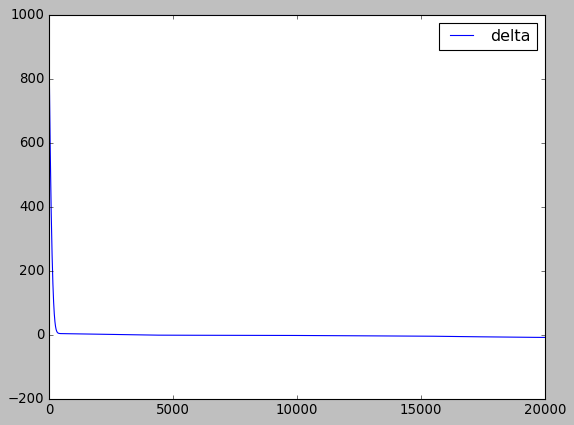

In [81]:
plt.plot(loss_tau, label='tau')
plt.legend()
plt.show()

## Delta term

In [82]:
delta = NPLMupgrade(input_shape=input_shape, N_Bkg=N_Bkg,
                   NUmatrix=NUmatrix, NURmatrix=NURmatrix, NU0matrix=NU0matrix, SIGMAmatrix=SIGMAmatrix,
                   A0matrix=A0matrix, A1matrix=A1matrix, A2matrix=A2matrix,
                   points=points, binned_features=binned_features,
                   edgebinlist=edgebinlist,  means=means,
                   ParNet_weights=ParNet_weights, correction='PAR',
                   architecture=layers, weight_clipping=weight_clipping, train_f=False, newpar=True)

print(delta.summary())

Model: "npl_mupgrade_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
parametric_net_6 (Parametric multiple                  13        
Total params: 21
Trainable params: 2
Non-trainable params: 19
_________________________________________________________________
None


In [83]:
opt  = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.0000001)
delta.compile(loss=NPLLoss_New,  optimizer=opt)

In [84]:
t0=time.time()
hist_delta = delta.fit(feature, target, batch_size=batch_size, epochs=total_epochs_delta, verbose=False)
t1=time.time()
print('Training time (seconds):')
print(t1-t0)

Training time (seconds):
382.2844567298889


In [85]:
# metrics                                                                                                                                                        
loss_delta  = np.array(hist_delta.history['loss'])
scale_delta = np.array(hist_delta.history['scale'])
norm_delta  = np.array(hist_delta.history['norm'])
print('sb_opt: %f, eb_opt: %f'%(scale_delta[-1], norm_delta[-1]))

# test statistic                                                                                                                                                                                                                                                                                                               
final_loss   = loss_delta[-1]
delta_OBS    = -2*final_loss

sb_opt: 0.017392, eb_opt: 0.037320


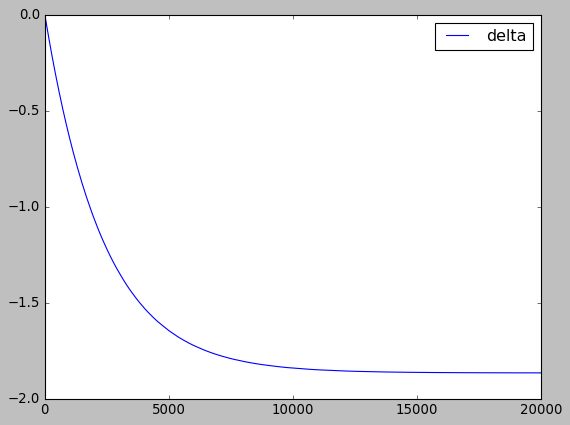

In [86]:
plt.plot(loss_delta, label='delta')
plt.legend()
plt.show()

# NN reconstruction

In [87]:
REF    = feature[target[:, 0]==0]
DATA   = feature[target[:, 0]==1]
weight = target[:, 1]

weight_REF       = weight[target[:, 0]==0]
weight_DATA      = weight[target[:, 0]==1]
output_delta_ref = delta.predict(REF)
output_tau_ref   = tau.predict(REF)

<ipython-input-88-3eda9a844a5f>:30: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
<ipython-input-88-3eda9a844a5f>:31: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)
<ipython-input-88-3eda9a844a5f>:32: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN2[0]/hR[0], ls='--', label =r'$\Delta$ RECO/REF', color='#33a02c', lw=3)


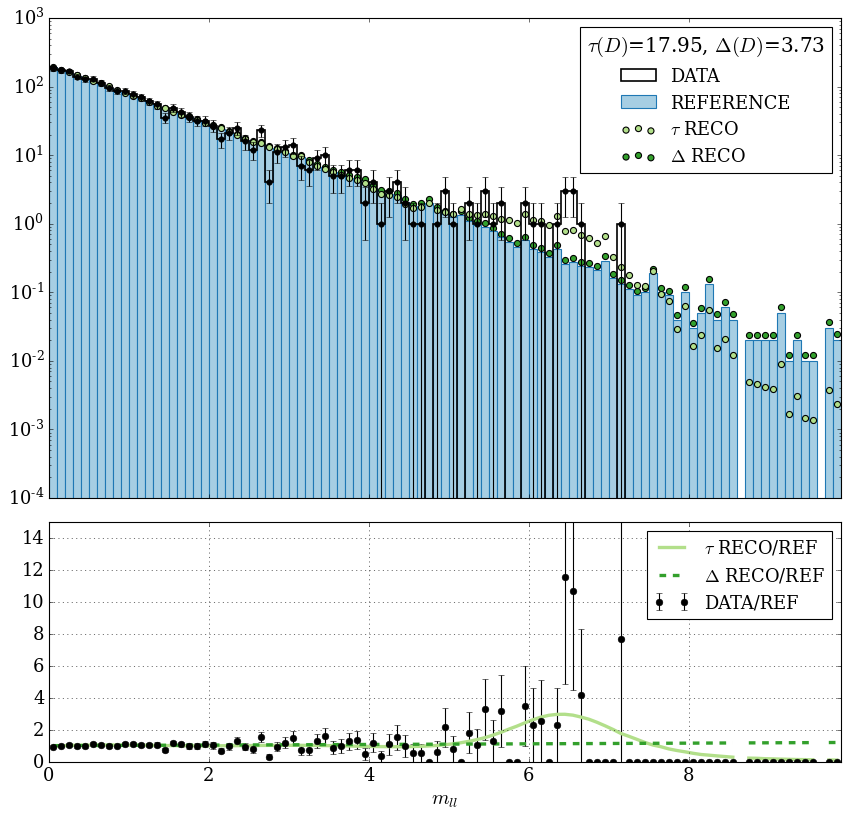

In [88]:
plt_i = 0
for key in feature_labels:
    bins = bins_code[key]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(10, 10))                                                                                                                                            
    fig.patch.set_facecolor('white')                                                                                                                                              
    ax1 = fig.add_axes([0., 0.33, 0.99, 0.6])        
    hD = plt.hist(DATA[:, plt_i],weights=weight_DATA, 
                  bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=4)
    hR = plt.hist(REF[:, plt_i], weights=weight_REF, color='#a6cee3',     
                  ec='#1f78b4', bins=bins, lw=1, label='REFERENCE')
    hN = plt.hist(REF[:, plt_i], weights=np.exp(output_tau_ref[:, 0])*weight_REF, 
                  histtype='step', bins=bins, lw=0)
    hN2= plt.hist(REF[:, plt_i], weights=np.exp(output_delta_ref[:, 0])*weight_REF, 
                  histtype='step', bins=bins, lw=0)
    plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
    plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN[0],  edgecolor='black', label=r'$\tau$ RECO',   color='#b2df8a', lw=1, s=30, zorder=2)
    plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN2[0], edgecolor='black', label=r'$\Delta$ RECO', color='#33a02c', lw=1, s=30, zorder=1)
    font = font_manager.FontProperties(family='serif', size=16)
    l    = plt.legend(fontsize=18, prop=font)
    font = font_manager.FontProperties(family='serif', size=18) 
    l.set_title(title=r'$\tau(D)$='+str(np.around(tau_OBS, 2))+r', $\Delta(D)$='+str(np.around(delta_OBS, 2)), prop=font)
    plt.tick_params(axis='x', which='both',    labelbottom=False)
    plt.yticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    plt.yscale('log')
    ax2 = fig.add_axes([0., 0., 0.99, 0.3]) 
    x = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
    plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)
    plt.plot(x, hN2[0]/hR[0], ls='--', label =r'$\Delta$ RECO/REF', color='#33a02c', lw=3)
    font = font_manager.FontProperties(family='serif', size=16)
    plt.legend(fontsize=18, prop=font)
    plt.xlabel(xlabel_code[key], fontsize=18, fontname='serif')
    plt.ylim(0., ymax_code[key])
    plt.yticks(fontsize=16, fontname='serif')
    plt.xticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    
    plt.grid() 
    plt.show()
    plt_i+=1

<ipython-input-64-3eda9a844a5f>:30: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
<ipython-input-64-3eda9a844a5f>:31: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)
<ipython-input-64-3eda9a844a5f>:32: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, hN2[0]/hR[0], ls='--', label =r'$\Delta$ RECO/REF', color='#33a02c', lw=3)


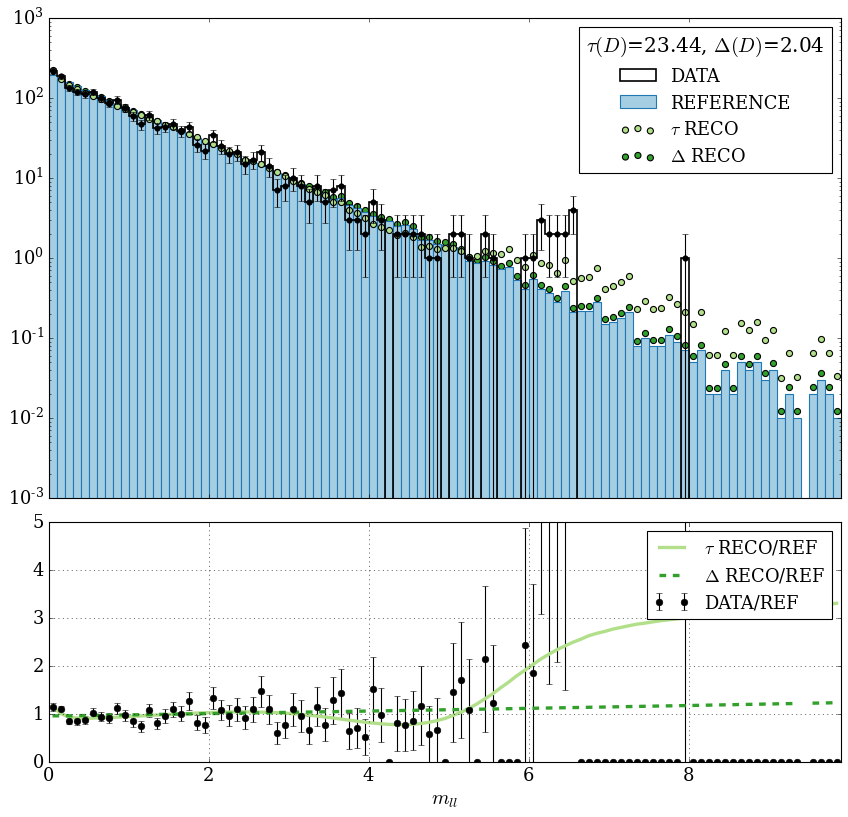

In [64]:
plt_i = 0
for key in feature_labels:
    bins = bins_code[key]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(10, 10))                                                                                                                                            
    fig.patch.set_facecolor('white')                                                                                                                                              
    ax1 = fig.add_axes([0., 0.33, 0.99, 0.6])        
    hD = plt.hist(DATA[:, plt_i],weights=weight_DATA, 
                  bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=4)
    hR = plt.hist(REF[:, plt_i], weights=weight_REF, color='#a6cee3',     
                  ec='#1f78b4', bins=bins, lw=1, label='REFERENCE')
    hN = plt.hist(REF[:, plt_i], weights=np.exp(output_tau_ref[:, 0])*weight_REF, 
                  histtype='step', bins=bins, lw=0)
    hN2= plt.hist(REF[:, plt_i], weights=np.exp(output_delta_ref[:, 0])*weight_REF, 
                  histtype='step', bins=bins, lw=0)
    plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0],  yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
    plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN[0],  edgecolor='black', label=r'$\tau$ RECO',   color='#b2df8a', lw=1, s=30, zorder=2)
    plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN2[0], edgecolor='black', label=r'$\Delta$ RECO', color='#33a02c', lw=1, s=30, zorder=1)
    font = font_manager.FontProperties(family='serif', size=16)
    l    = plt.legend(fontsize=18, prop=font)
    font = font_manager.FontProperties(family='serif', size=18) 
    l.set_title(title=r'$\tau(D)$='+str(np.around(tau_OBS, 2))+r', $\Delta(D)$='+str(np.around(delta_OBS, 2)), prop=font)
    plt.tick_params(axis='x', which='both',    labelbottom=False)
    plt.yticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    plt.yscale('log')
    ax2 = fig.add_axes([0., 0., 0.99, 0.3]) 
    x = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, hD[0]/hR[0], yerr=np.sqrt(hD[0])/hR[0], ls='', marker='o', label ='DATA/REF', color='black')
    plt.plot(x, hN[0]/hR[0], label =r'$\tau$ RECO/REF', color='#b2df8a', lw=3)
    plt.plot(x, hN2[0]/hR[0], ls='--', label =r'$\Delta$ RECO/REF', color='#33a02c', lw=3)
    font = font_manager.FontProperties(family='serif', size=16)
    plt.legend(fontsize=18, prop=font)
    plt.xlabel(xlabel_code[key], fontsize=18, fontname='serif')
    plt.ylim(0., ymax_code[key])
    plt.yticks(fontsize=16, fontname='serif')
    plt.xticks(fontsize=16, fontname='serif')
    plt.xlim(bins[0], bins[-1])
    
    plt.grid() 
    plt.show()
    plt_i+=1

In [8]:
norm.ppf(chi2.cdf(21, 13))

1.4543212809986954

In [9]:
norm.ppf(chi2.cdf(15, 13))

0.5033680231780606

In [11]:
norm.ppf(chi2.cdf(40, 13))

3.636403664622847